In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# MNIST Data Pre-processing
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils  # utilities for one-hot encoding of ground truth values

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train, 10).astype(np.float32)
y_test = np_utils.to_categorical(y_test, 10).astype(np.float32)

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from AdvGAN import AdvGAN

Gan, G, D, F = AdvGAN([28,28,1], 'B', 2, 1)

epochs=100
batch_size=128

target=0

x_train_selected = x_train
y_train_selected = y_train

for cur_epoch in range(epochs):
    for discrm_epoch in range(4):
        input_batch = x_train_selected[np.random.randint(0, x_train_selected.shape[0], size=int(batch_size)),]
        y_discrim = np.ones([batch_size,1])
        if discrm_epoch % 2 == 0:
            input_batch = np.add(input_batch, G.predict(input_batch))
            y_discrim = np.zeros([batch_size,1])
        D.train_on_batch(input_batch, y_discrim)
        
    input_idx = np.random.randint(0, x_train_selected.shape[0], size=int(batch_size))
    input_batch = x_train_selected[input_idx,]
    y_discrim = np.ones([batch_size,1])
    #y_class = y_train_selected[input_idx,]
    y_class=np_utils.to_categorical(np.ones(batch_size)*target, 10).astype(np.float32)
    y_hinge=np.zeros([batch_size,28,28,1])
    scalarloss=Gan.train_on_batch(input_batch, [y_discrim, y_class, y_hinge])
    print("Epoch number:",cur_epoch,"; Loss",scalarloss)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch number: 0 ; Loss [2.6149936, 0.77164805, 0.74812305, 0.34709942]
Epoch number: 1 ; Loss [2.5288846, 0.72263086, 0.73657644, 0.33310097]
Epoch number: 2 ; Loss [2.6584556, 0.7477292, 0.792163, 0.3264005]
Epoch number: 3 ; Loss [2.6565504, 0.8483019, 0.77013355, 0.2679816]
Epoch number: 4 ; Loss [2.6273894, 0.8901037, 0.7524711, 0.23234355]
Epoch number: 5 ; Loss [2.7686586, 0.9276407, 0.8123635, 0.2162909]
Epoch number: 6 ; Loss [2.6726992, 0.9477054, 0.7653657, 0.19426231]
Epoch number: 7 ; Loss [2.5173497, 0.9251208, 0.7134501, 0.16532862]
Epoch number: 8 ; Loss [2.5484529, 0.90491575, 0.74442834, 0.15468052]
Epoch number: 9 ; Loss [2.589469, 0.93507874, 0.74243265, 0.16952486]
Epoch number: 10 ; Loss [2.664586, 0.9549008, 0.7577908, 0.19410366]
Epoch number: 11 ; Loss [2.6849637, 0.96013355, 0.7577672, 0.20929565]
Epoch number: 12 ; Loss [2.6257613, 0.9539509, 0.7280524, 0.2157057]
Epoch number: 13 ; Loss [2.6066432, 0.9470098, 0.7228733, 0.21388665]
Epoch number: 14 ; Loss [2.

In [4]:
import matplotlib.pyplot as plt
import pickle

idx = range(x_train.shape[0])
#idx = np.random.randint(0, x_train_selected.shape[0], size=int(1000))
real = x_train[idx,]
fake = real + G.predict(real)
pdt = np.argmax(Gan.predict(real)[1], axis=1)
label = np.argmax(y_train[idx,], axis=1)
idx = np.logical_and(pdt != label, pdt == target)
real = real[idx,]
fake = fake[idx,]
pdt = pdt[idx,]
label = label[idx,]
idx = np.argsort(np.mean((real-fake)**2, axis=(1,2,3)))
real = real[idx,]
fake = fake[idx,]
pdt = pdt[idx,]
label = label[idx,]

In [5]:
print(label.shape)
print(pdt.shape)
print(real.shape)
print(fake.shape)

np.save('samples/WB-B-t%d-label.npy' % target, label)
np.save('samples/WB-B-t%d-target.npy' % target, pdt)
np.save('samples/WB-B-t%d-clean.npy' % target, real)
np.save('samples/WB-B-t%d-adv.npy' % target, fake)

(53810,)
(53810,)
(53810, 28, 28, 1)
(53810, 28, 28, 1)


In [6]:
unique, counts = np.unique(10*label+pdt, return_counts=True)
print('Num of types:', len(unique))
print('Num of adv samples:', sum(counts))
print('Statistics:', dict(zip(unique, counts)))

Num of types: 9
Num of adv samples: 53810
Statistics: {49: 5794, 19: 6724, 69: 5908, 89: 5839, 39: 6098, 9: 5911, 59: 5406, 29: 5899, 79: 6231}


7
9


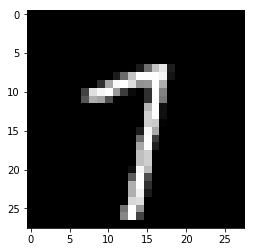

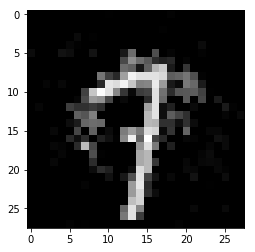

7
9


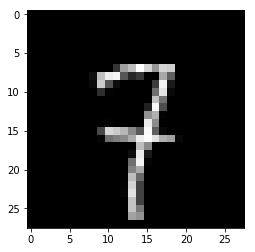

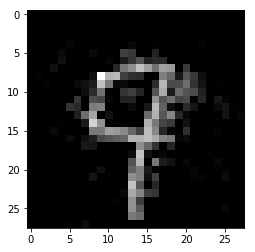

7
9


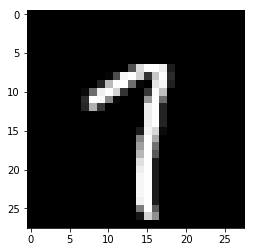

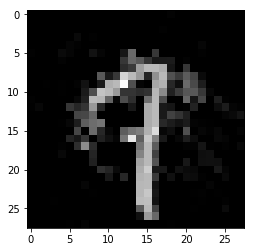

7
9


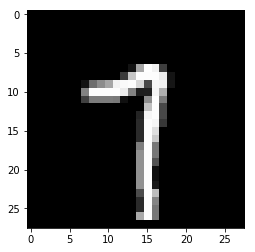

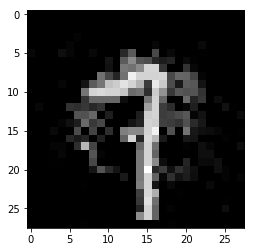

1
9


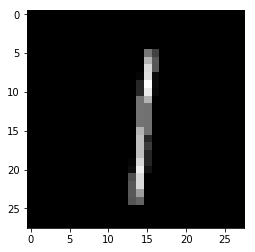

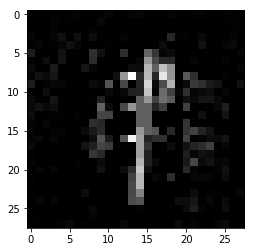

7
9


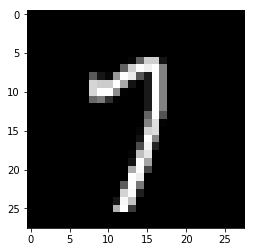

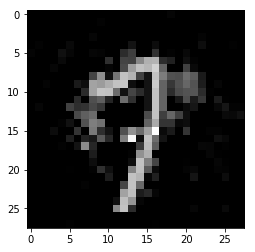

7
9


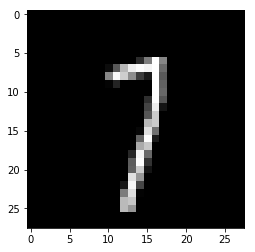

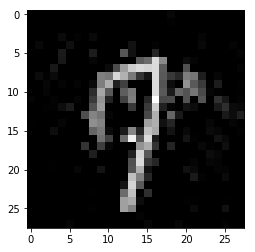

7
9


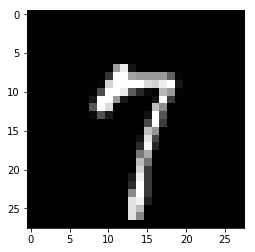

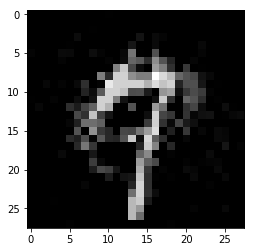

7
9


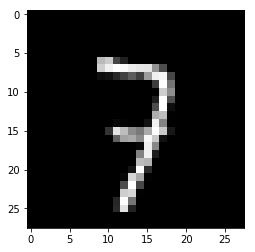

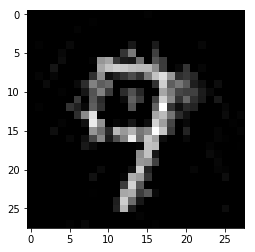

1
9


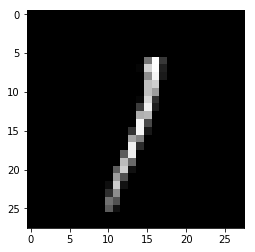

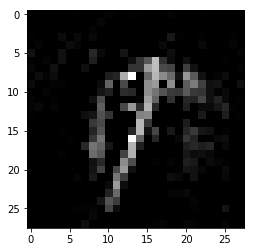

7
9


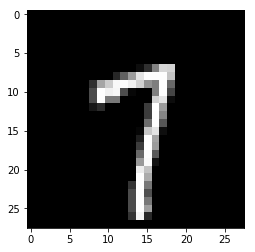

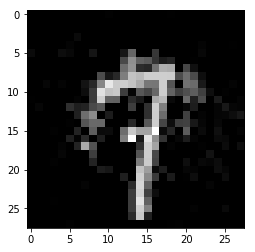

7
9


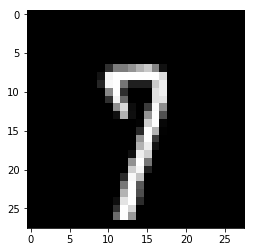

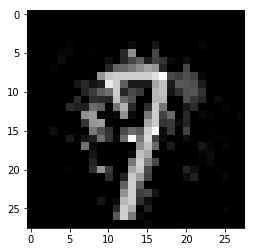

7
9


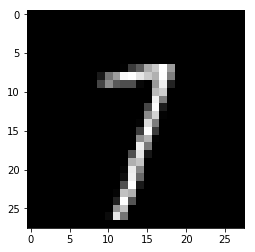

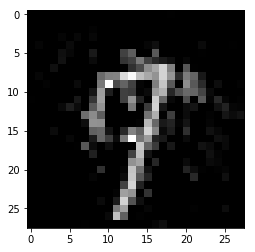

7
9


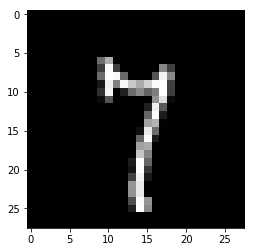

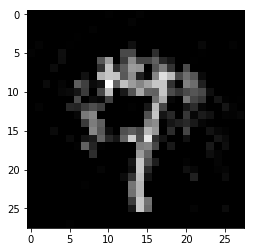

5
9


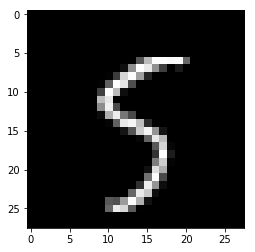

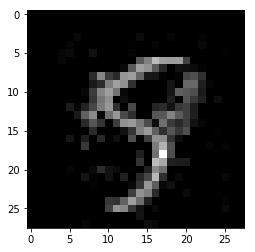

7
9


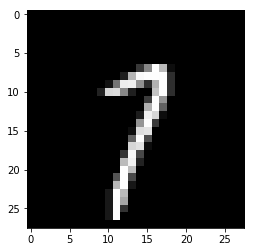

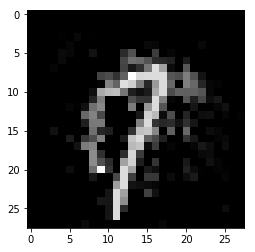

7
9


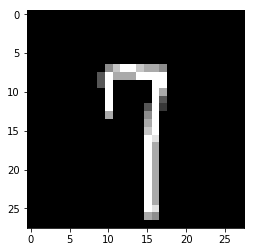

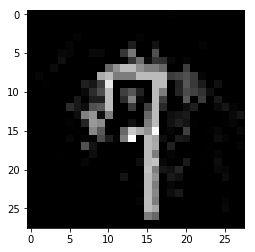

7
9


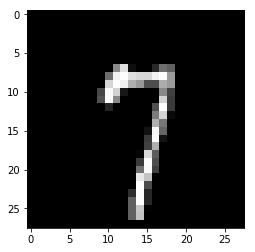

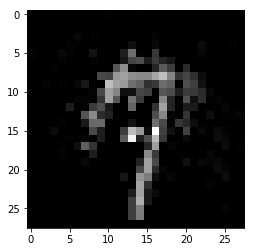

1
9


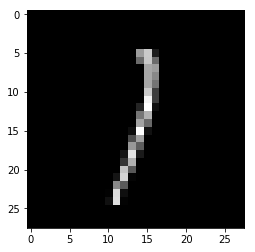

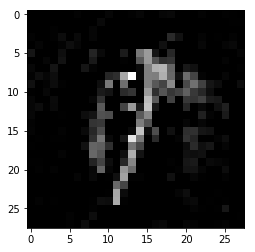

7
9


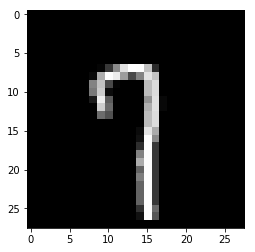

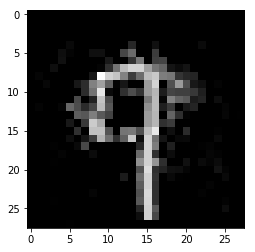

In [7]:
for k in range(20):
    print(label[k,])
    print(pdt[k,])
    plt.imshow((real[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()
    plt.imshow((fake[k,] * 255).astype(np.int).reshape(28,28), cmap='gray')
    plt.show()

In [8]:
image = np.zeros((280,280,1))

c = {}

for i in range(10):
    for j in range(10):
        idx = np.logical_and(label==i, pdt==j)
        if (10*i+j) in d and (10*i+j) not in c:
            c[10*i+j] = fake[idx][0]
        image[28*i:28*(i+1),28*j:28*(j+1),:] = c[10*i+j] if (10*i+j) in c else np.zeros((28,28,1))
        
print(len(c.keys()))

plt.figure(figsize=(10,10))
plt.imshow(np.clip(image*255, 0, 255).astype(np.int).reshape(280,280), cmap='gray')
plt.show()

NameError: name 'd' is not defined

In [ ]:
with open('WB-C.pickle', 'rb') as handle:
    record = pickle.load(handle)

In [ ]:
d = dict(zip(unique, counts))
n = np.zeros((10,10))
m = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        n[i,j] = d[10*i+j] if (10*i+j) in d else int(i!=j)
        idx = np.logical_and(label==i, pdt==j)
        m[i,j] = np.median(np.mean((real[idx,]-fake[idx,])**2, axis=(1,2,3))) if (10*i+j) in d else float(i!=j)*0.07

import seaborn
plt.figure(figsize=(10,8))
plt.xlabel('adasd')
n = np.log(n+1)*0.015
seaborn.heatmap(n)
#seaborn.heatmap(m)